[https://openclassrooms.com/fr/paths/164/projects/627/assignment](https://openclassrooms.com/fr/paths/164/projects/627/assignment)



## Preamble



In [63]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Objectifs



Déterminer si les [données sur l’éducation de la banque mondiale](https://datacatalog.worldbank.org/dataset/education-statistics) permettent
d’informer le projet d’expansion de l'entreprise.

-   Quels sont les pays avec un fort potentiel de clients pour nos services ?
-   Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
-   Dans quels pays l'entreprise doit-elle opérer en priorité ?



## Analyse exploratoire



-   Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données
    manquantes, dupliquées ?)
-   Décrire les informations contenues dans le jeu de données (nombre de colonnes
    ? nombre de lignes ?)
-   Sélectionner les informations qui semblent pertinentes pour répondre à la
    problématique (quelles sont les colonnes contenant des informations qui
    peuvent être utiles pour répondre à la problématique de l’entreprise ?)
-   Déterminer des ordres de grandeurs des indicateurs statistiques classiques
    pour les différentes zones géographiques et pays du monde
    (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)



### Objectif 1 : Créer une boucle for pour récupérer pour chaque fichier le nombre de ligne , de variable , le type de variable et le nombre de valeur manquante



    ls data/  



In [2]:
ed_sets = {'country_series': 'EdStatsCountry-Series.csv',
           'foot_note': 'EdStatsFootNote.csv',
           'country': 'EdStatsCountry.csv',
           'series': 'EdStatsSeries.csv',
           'data': 'EdStatsData.csv'}

In [3]:
for key, val in ed_sets.items():
    exec("file = 'data/" + val + "'")
    exec(key + "= pd.read_csv(file)")
    print("--- " + val)
    exec("print(" + key + ".shape)")
    exec("print(" + key + ".isna().sum())")

--- EdStatsCountry-Series.csv
(613, 4)
CountryCode      0
SeriesCode       0
DESCRIPTION      0
Unnamed: 3     613
dtype: int64
--- EdStatsFootNote.csv
(643638, 5)
CountryCode         0
SeriesCode          0
Year                0
DESCRIPTION         0
Unnamed: 4     643638
dtype: int64
--- EdStatsCountry.csv
(241, 32)
Country Code                                           0
Short Name                                             0
Table Name                                             0
Long Name                                              0
2-alpha code                                           3
Currency Unit                                         26
Special Notes                                         96
Region                                                27
Income Group                                          27
WB-2 code                                              1
National accounts base year                           36
National accounts reference year                     

-   We can safely remove the last column of all the datasets:



In [4]:
del data['Unnamed: 69']
del series['Unnamed: 20']
del country['Unnamed: 31']
del foot_note['Unnamed: 4']
del country_series['Unnamed: 3']

-   Do we find every indicator from the series table in our main dataset ?



In [5]:
print(len(data['Indicator Code'].unique()))

3665


-   3665 indicators for 241 countries equals to 883 265, a little less than the
    886 930 rows of our main data. Do we have the same number of countries in the
    latter ?



In [6]:
print(len(data['Country Code'].unique()))

242


In [7]:
for i in list(set(data['Country Code'].unique()) - set(country['Country Code'].unique())):
      print(data.loc[data['Country Code'] == i])

                  Country Name Country Code  \
190580  British Virgin Islands          VGB   
190581  British Virgin Islands          VGB   
190582  British Virgin Islands          VGB   
190583  British Virgin Islands          VGB   
190584  British Virgin Islands          VGB   
...                        ...          ...   
194240  British Virgin Islands          VGB   
194241  British Virgin Islands          VGB   
194242  British Virgin Islands          VGB   
194243  British Virgin Islands          VGB   
194244  British Virgin Islands          VGB   

                                           Indicator Name  \
190580  Adjusted net enrolment rate, lower secondary, ...   
190581  Adjusted net enrolment rate, lower secondary, ...   
190582  Adjusted net enrolment rate, lower secondary, ...   
190583  Adjusted net enrolment rate, lower secondary, ...   
190584  Adjusted net enrolment rate, primary, both sex...   
...                                                   ...   
194240  

In [8]:
print(country[country['Long Name'].str.contains('Islands')])

    Country Code                Short Name                Table Name  \
35           CHI           Channel Islands           Channel Islands   
48           CYM            Cayman Islands            Cayman Islands   
72           FRO            Faeroe Islands            Faeroe Islands   
142          MHL          Marshall Islands          Marshall Islands   
151          MNP  Northern Mariana Islands  Northern Mariana Islands   
192          SLB           Solomon Islands           Solomon Islands   
210          TCA  Turks and Caicos Islands  Turks and Caicos Islands   
231          VIR            Virgin Islands     Virgin Islands (U.S.)   

                                        Long Name 2-alpha code  \
35                                Channel Islands          NaN   
48                                 Cayman Islands           KY   
72                                 Faeroe Islands           FO   
142              Republic of the Marshall Islands           MH   
151  Commonwealth of 

### Objectif 2 : Identifier les variables inutilisables

In [94]:
france = data[data['Country Code'] == 'FRA']
indicators = france['Indicator Code'].unique()
years = france[france.columns[4:]]
num_ind = years.shape[0]
num_years = years.shape[1]
years=years.columns

na_rows = []
for i in indicators:
    na_rows.append(num_years - int(france[france['Indicator Code'] == i].isnull().sum(axis=1)))

na_cols = []
for i in years:
    na_cols.append(num_ind - int(france[i].isnull().sum(axis=0)))

In [95]:
print(years)

Index(['1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996',
       '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005',
       '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045',
       '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090',
       '2095', '2100'],
      dtype='object')


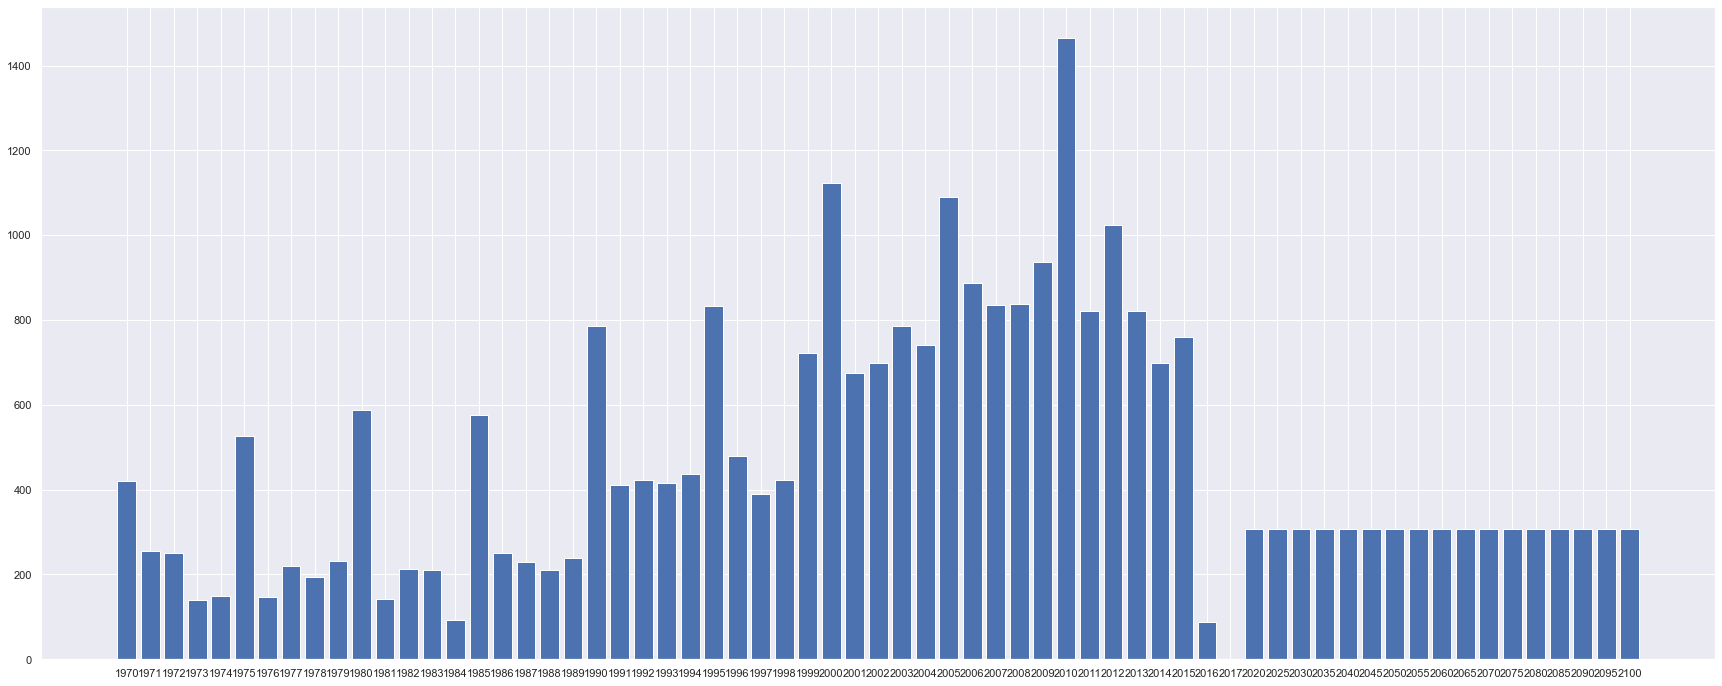

In [116]:
plt.figure(figsize = (30,12))
plt.bar(years,na_cols)
plt.show()

- Indicators are mostly availables for the years between 2000 and 2015. Some indicators are clearly cyclic by a period of 5 years. Some indicators are consistently filled/forcasted from 2020 to 2100.

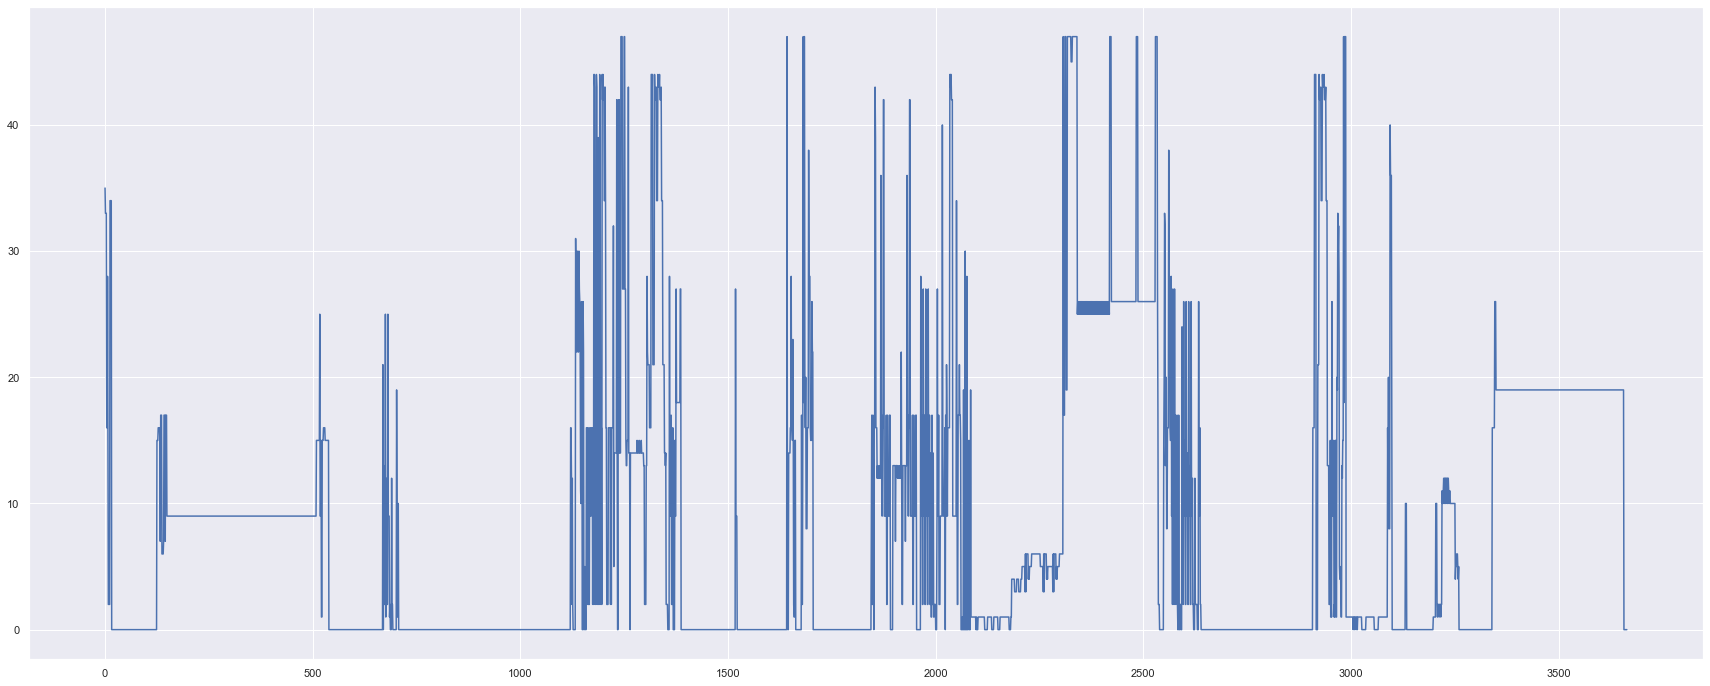

In [118]:
plt.figure(figsize = (30,12))
plt.plot(na_rows)
plt.show()

/Users/lss/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/joypy/joyplot.py:224: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


AttributeError: 'tuple' object has no attribute 'show'

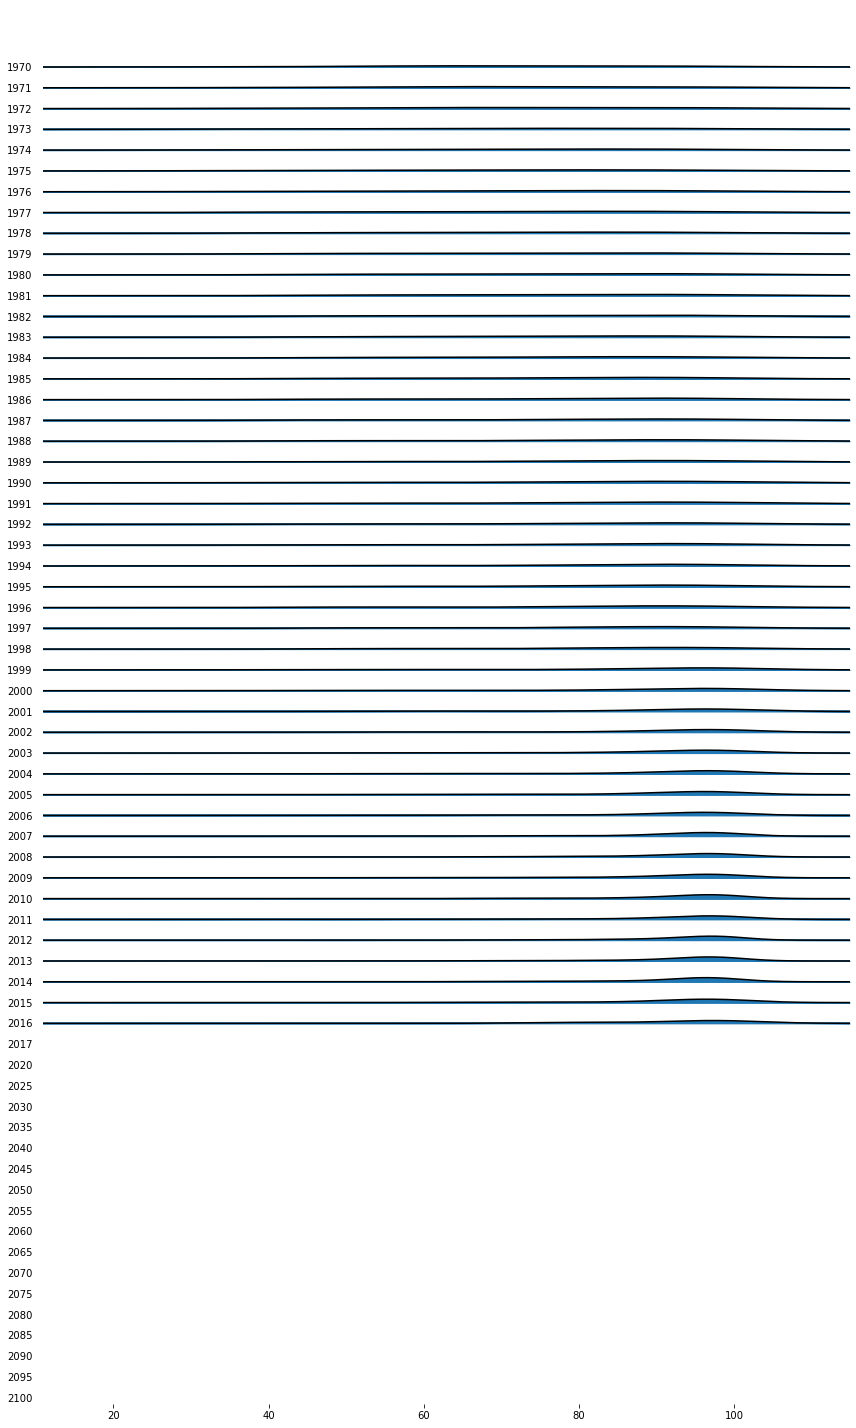

In [14]:
from joypy import joyplot

years = data[data.columns[3:]]

#print(years.head())

years = years[years['Indicator Code'] == 'SE.PRM.TENR']

fig, axes = joyplot(years, figsize=(12,20))

plt.show()

### Objectif 3 : Remplacer les valeurs manquantes sur les autres variables / gérer les valeurs aberrantes



### Objectif 4 : Ecrire un descriptif de chaque fichier



### Objectif 5 : Formulation de la problématique et comment y répondre



### Objectif 6 : Réfléchir aux variables pour répondre a la problématique



### Objectif 7 : Commencer le support

